In [1]:
"""Continuous one class svm."""

%matplotlib inline

import numpy as np

from bokeh.plotting import figure
from bokeh.models import Slider, CustomJS, ColumnDataSource
from bokeh.io import output_file, show, vform

from scipy.spatial.distance import pdist, squareform
from scipy.linalg import sqrtm
from sklearn.kernel_approximation import RBFSampler, SkewedChi2Sampler
from sklearn.preprocessing import StandardScaler

from IPython.display import display, Math, Latex

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [52]:
display(Math(r'f^* = \text{agmin}_{f,\tau}\displaystyle\sum_{i=1}^N\max(0, f(x_i) - \tau) + \nu||f||^2 - \nu\tau '))


display(Math(r'f^* = \text{agmin}_{f,\tau}\displaystyle\sum_{i=1}^N\int_{[0,1]}\max(0, f(x_i, \nu) - \tau(\nu))d\nu + \int_{[0,1]}\nu||f||^2d\nu - \int_{[0,1]}\nu\tau(\nu)d\nu'))


display(Math(r'f^* = \text{agmin}_{f,\tau}\displaystyle\sum_{i=1}^N\int_{[0,1]}\max(0, f(x_i, \nu) - \tau(\nu))d\nu + \int_{[0,1]}\nu||f(., \nu)||^2d\nu - \int_{[0,1]}\nu\tau(\nu)d\nu'))

class OCCSVM:

    def __init__(self, gamma=1., nu=0.5, step=1., T=50, D1=500, D2=100, s=10, n_nus=100):
        self.gamma = gamma
        self.step = step
        self.T = T
        self.D1 = D1
        self.D2 = D2
        self.s = s
        self.nu = nu
        self.n_nus = n_nus

    def _predict(self, phiX, theta, B):
        return np.dot(np.dot(phiX, theta), B)
    
    def fit(self, X):
        # INITIALISATION
        scal = StandardScaler()
        scal.fit(X)
        Xs = scal.transform(X)

        phi1 = RBFSampler(gamma=self.gamma, n_components=self.D1, random_state=0)
        phiX1 = phi1.fit_transform(Xs)
        phi2 = RBFSampler(gamma=1. / self.s, n_components=self.D2, random_state=0)

        self._theta1 = np.zeros((self.D1, self.D2))
        self._theta2 = np.zeros(self.D2)
        
        # GRADIENT LEARNING
        for t in range(self.T):
            for nu in np.linspace(-1, 1, self.s):
                rnu = (nu + 1) / 2
                B = phi2.fit_transform(np.array([[nu]]))
                pred = self._predict(phiX1, self._theta1, B.T)
                tau = np.dot(B, self._theta2)
                res = (pred - tau < 0).astype(np.float)
                grad_loss_f = np.dot(np.dot(phiX1.T, -res), B) / X.shape[0]
                grad_reg = rnu * self._theta1
                grad_loss_tau = ((np.mean(res, axis=0) - rnu) * B).ravel()
                self._theta1 = self._theta1 - self.step * (grad_loss_f + grad_reg)
                self._theta2 = self._theta2 - self.step * grad_loss_tau

        # FINALISATION
        self._f = lambda Xt, nu: self._predict(phi1.transform(scal.transform(Xt)), 
                                               self._theta1, 
                                               phi2.transform(nu * 2 - 1).T)
        self._r = lambda nu: np.dot(phi2.transform(nu * 2 - 1), self._theta2)
        
        self._nus = np.linspace(0, 1, self.n_nus).reshape((self.n_nus, 1))
        self._C = np.mean(self._f(X, self._nus) - self._r(self._nus) >= 0, axis=0)
        
        def fs(Xt, split):
            return self._f(Xt, float(self._nus[np.argmax(self._C <= split)]))

        def rs(split):
            return self._r(float(self._nus[np.argmax(self._C <= split)]))

        self._fs = fs
        self._rs = rs
    
    def decision_function(self, Xt, split=None):
        if split is None:
            split = self.nu
        return (self._fs(Xt, 1 - split) - self._rs(1 - split)).ravel()
    
    def predict(self, Xt, split=None):
        return 2 * (self.decision_function(Xt, split) >= 0).astype(np.float) - 1


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

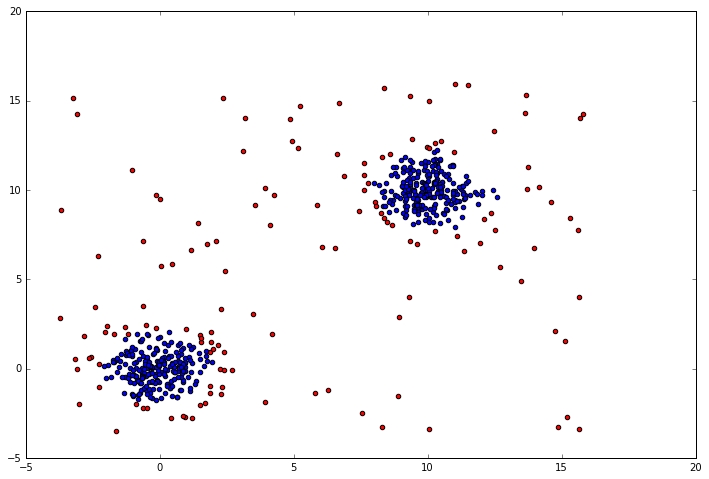

In [53]:
n1 = 250
n2 = 250
n3 = 0
np.random.seed(0)
Xi = np.concatenate((np.random.randn(n1, 2),
                     10 + np.random.randn(n2, 2),
                     np.array([5, 5]) + np.random.randn(n3, 2)))
Xo = 20 * (np.random.rand(100, 2) -.2)
X = np.concatenate((Xi, Xo))
y = np.empty(Xi.shape[0] + Xo.shape[0])
y[:Xi.shape[0]] = 1
y[Xi.shape[0]:] = 0

estimator = OCCSVM(gamma=1.5, D2=100)
estimator.fit(Xi)

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from ipywidgets import interact, FloatSlider, RadioButtons

Xt = np.empty((10000, 2))
# Xt[:, 0] = np.random.uniform(-5, 15, 10000)
# Xt[:, 1] = np.random.uniform(-5, 15, 10000)
Xt = X

nu_slider = FloatSlider(min=.0, max=1.0, step=0.01, value=0.12)
# decorate the plot function with an environment from the UIs:
@interact(nu=nu_slider)
def plot(nu):
    plt.figure(figsize=(12, 8))
    plt.subplot(1, 1, 1)

#     ax.grid(color='w', linewidth=2, linestyle='solid')
    x = np.linspace(0, 10, 1000)
    plt.scatter(Xt[estimator.decision_function(Xt, nu) < 0, 0], 
                Xt[estimator.decision_function(Xt, nu) < 0, 1], c='r')
    plt.scatter(Xt[estimator.decision_function(Xt, nu) >= 0, 0], 
                Xt[estimator.decision_function(Xt, nu) >= 0, 1], c='b')
#     ax.set_xlim(-5, 15)
#     ax.set_ylim(-5, 15)

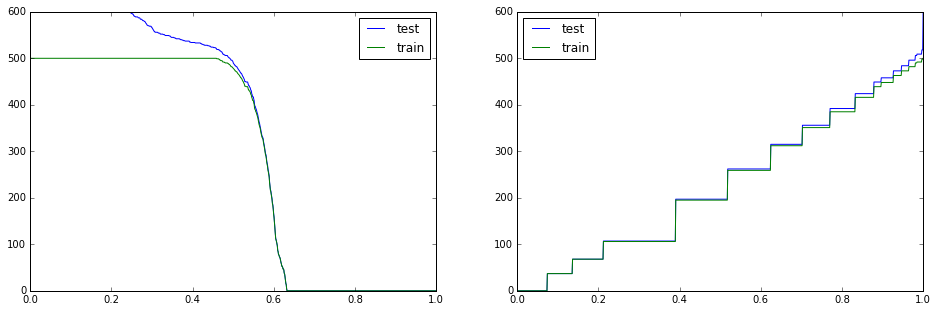

In [55]:
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
h1, = plt.plot(np.linspace(0, 1, 1000), 
         np.array([np.sum(estimator._f(X, nu) - estimator._r(nu) > 0) for nu in np.linspace(0, 1, 1000)]))
h2, = plt.plot(np.linspace(0, 1, 1000), 
         np.array([np.sum(estimator._f(Xi, nu) - estimator._r(nu) > 0) for nu in np.linspace(0, 1, 1000)]))
plt.legend([h1, h2], ['test', 'train'], loc=1)

plt.subplot(1, 2, 2)
h3, = plt.plot(np.linspace(0, 1, 1000), 
         np.array([np.sum(estimator._fs(X, nu) - estimator._rs(nu) > 0) for nu in np.linspace(0, 1, 1000)]))
h4, = plt.plot(np.linspace(0, 1, 1000), 
         np.array([np.sum(estimator._fs(Xi, nu) - estimator._rs(nu) > 0) for nu in np.linspace(0, 1, 1000)]))
plt.legend([h3, h4], ['test', 'train'], loc=2)

('T fit OCSVM:', 0.006281852722167969)
('T fit OCSVM:', 0.003895998001098633)
('T fit Robust Covariance (Minimum Covariance Determinant):', 0.4602019786834717)
('T fit Robust Covariance (Minimum Covariance Determinant):', 0.5001158714294434)
('T fit O2CSVM:', 0.5093369483947754)
('T fit O2CSVM:', 0.5035400390625)
('T fit Empirical Covariance:', 0.32370710372924805)
('T fit Empirical Covariance:', 0.32494592666625977)


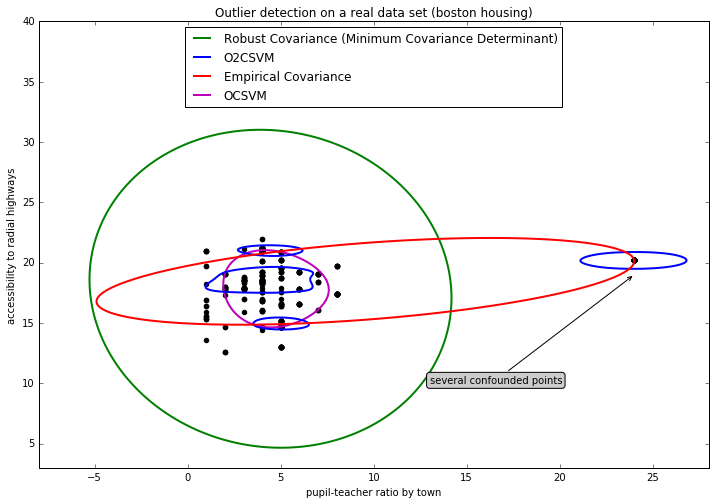

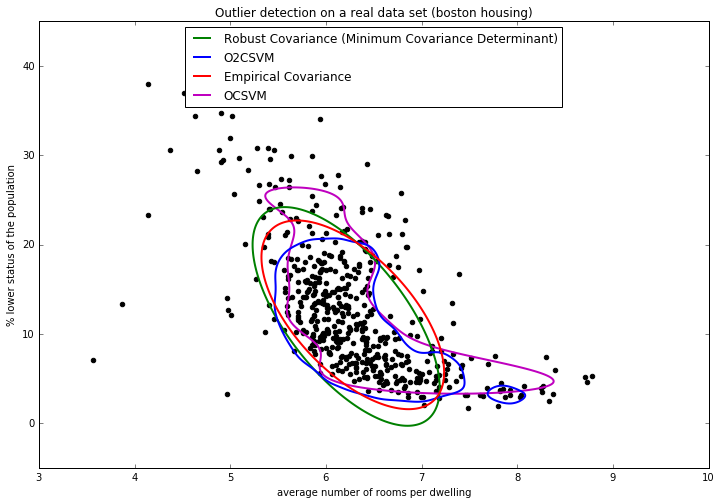

In [38]:
# Author: Virgile Fritsch <virgile.fritsch@inria.fr>
# License: BSD 3 clause

import numpy as np
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn.datasets import load_boston
import time

# Get data
X1 = load_boston()['data'][:, [8, 10]]  # two clusters
X2 = load_boston()['data'][:, [5, 12]]  # "banana"-shaped

# Define "classifiers" to be used
classifiers = {
    "Empirical Covariance": EllipticEnvelope(support_fraction=1.,
                                             contamination=0.261),
    "Robust Covariance (Minimum Covariance Determinant)":
    EllipticEnvelope(contamination=0.261),
    "OCSVM": OneClassSVM(nu=0.261, gamma=0.05),
    "O2CSVM": OCCSVM(gamma=12.5, nu=0.261, step=1., T=10, D1=1500)}
colors = ['m', 'g', 'b', 'r']
legend1 = {}
legend2 = {}

# Learn a frontier for outlier detection with several classifiers
xx1, yy1 = np.meshgrid(np.linspace(-8, 28, 500), np.linspace(3, 40, 500))
xx2, yy2 = np.meshgrid(np.linspace(3, 10, 500), np.linspace(-5, 45, 500))
for i, (clf_name, clf) in enumerate(classifiers.items()):
#     if clf_name is "O2CSVM":
#         clf.gamma = 2.5
#         clf.nu = 0.01
    plt.figure(1, figsize=(12, 8))
    start = time.time()
    clf.fit(X1)
    print ('T fit ' + clf_name + ':', time.time() - start)
    Z1 = clf.decision_function(np.c_[xx1.ravel(), yy1.ravel()])
    Z1 = Z1.reshape(xx1.shape)
    legend1[clf_name] = plt.contour(
        xx1, yy1, Z1, levels=[0], linewidths=2, colors=colors[i])
    
#     if clf_name is "O2CSVM":
#         clf.gamma = 12.5
#         clf.nu=0.261
    plt.figure(2, figsize=(12, 8))
    start = time.time()
    clf.fit(X2)
    print ('T fit ' + clf_name + ':', time.time() - start)
    Z2 = clf.decision_function(np.c_[xx2.ravel(), yy2.ravel()])
    Z2 = Z2.reshape(xx2.shape)
    legend2[clf_name] = plt.contour(
        xx2, yy2, Z2, levels=[0], linewidths=2, colors=colors[i])

legend1_values_list = list( legend1.values() )
legend1_keys_list = list( legend1.keys() )

# Plot the results (= shape of the data points cloud)
plt.figure(1, figsize=(12, 8))  # two clusters
plt.title("Outlier detection on a real data set (boston housing)")
plt.scatter(X1[:, 0], X1[:, 1], color='black')
bbox_args = dict(boxstyle="round", fc="0.8")
arrow_args = dict(arrowstyle="->")
plt.annotate("several confounded points", xy=(24, 19),
             xycoords="data", textcoords="data",
             xytext=(13, 10), bbox=bbox_args, arrowprops=arrow_args)
plt.xlim((xx1.min(), xx1.max()))
plt.ylim((yy1.min(), yy1.max()))
plt.legend((legend1_values_list[0].collections[0],
            legend1_values_list[1].collections[0],
            legend1_values_list[2].collections[0],
            legend1_values_list[3].collections[0]),
           (legend1_keys_list[0], legend1_keys_list[1], legend1_keys_list[2], legend1_keys_list[3]),
           loc="upper center",
           prop=matplotlib.font_manager.FontProperties(size=12))
plt.ylabel("accessibility to radial highways")
plt.xlabel("pupil-teacher ratio by town")

legend2_values_list = list( legend2.values() )
legend2_keys_list = list( legend2.keys() )

plt.figure(2, figsize=(12, 8))  # "banana" shape
plt.title("Outlier detection on a real data set (boston housing)")
plt.scatter(X2[:, 0], X2[:, 1], color='black')
plt.xlim((xx2.min(), xx2.max()))
plt.ylim((yy2.min(), yy2.max()))
plt.legend((legend2_values_list[0].collections[0],
            legend2_values_list[1].collections[0],
            legend2_values_list[2].collections[0],
            legend2_values_list[3].collections[0]),
           (legend2_keys_list[0], legend2_keys_list[1], legend2_keys_list[2], legend2_keys_list[3]),
           loc="upper center",
           prop=matplotlib.font_manager.FontProperties(size=12))
plt.ylabel("% lower status of the population")
plt.xlabel("average number of rooms per dwelling")

plt.show()

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:32: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:33: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


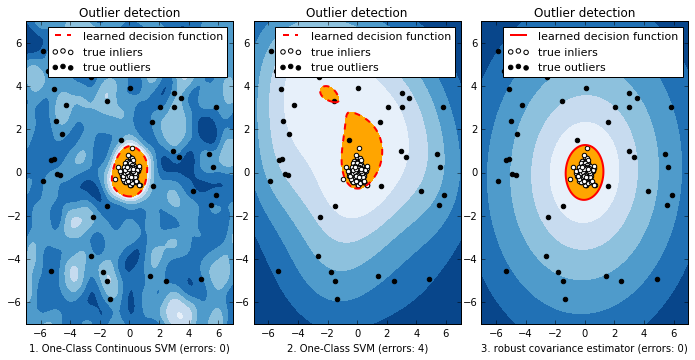

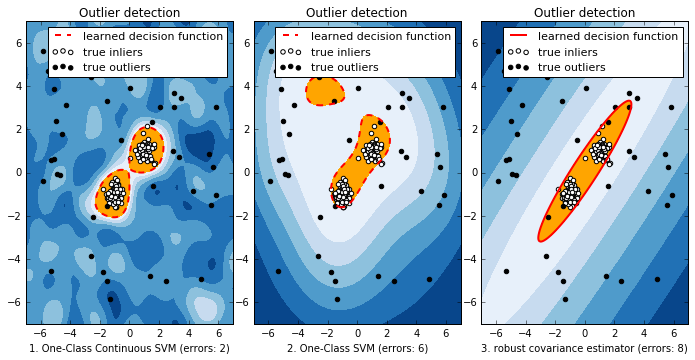

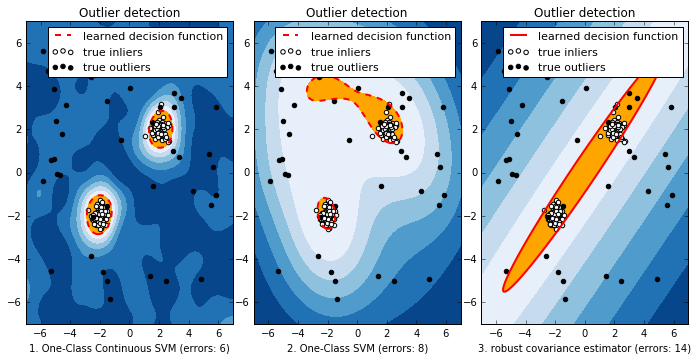

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
from scipy import stats

from sklearn import svm
from sklearn.covariance import EllipticEnvelope

# Example settings
n_samples = 200
outliers_fraction = 0.25
clusters_separation = [0, 1, 2]

# define two outlier detection tools to be compared
classifiers = {
    "One-Class SVM": svm.OneClassSVM(nu=0.95 * outliers_fraction + 0.05,
                                     kernel="rbf", gamma=0.1),
    "robust covariance estimator": EllipticEnvelope(contamination=.1),
    "One-Class Continuous SVM": OCCSVM(nu=0.95 * outliers_fraction + 0.05, gamma=5.)}

# Compare given classifiers under given settings
xx, yy = np.meshgrid(np.linspace(-7, 7, 500), np.linspace(-7, 7, 500))
n_inliers = int((1. - outliers_fraction) * n_samples)
n_outliers = int(outliers_fraction * n_samples)
ground_truth = np.ones(n_samples, dtype=int)
ground_truth[-n_outliers:] = 0

# Fit the problem with varying cluster separation
for i, offset in enumerate(clusters_separation):
    np.random.seed(42)
    # Data generation
    X1 = 0.3 * np.random.randn(0.5 * n_inliers, 2) - offset
    X2 = 0.3 * np.random.randn(0.5 * n_inliers, 2) + offset
    X = np.r_[X1, X2]
    # Add outliers
    X = np.r_[X, np.random.uniform(low=-6, high=6, size=(n_outliers, 2))]

    # Fit the model with the One-Class SVM
    plt.figure(figsize=(10, 5))
    for i, (clf_name, clf) in enumerate(classifiers.items()):
        # fit the data and tag outliers
        clf.fit(X)
        y_pred = clf.decision_function(X).ravel()
        threshold = stats.scoreatpercentile(y_pred,
                                            100 * outliers_fraction)
        y_pred = y_pred > threshold
        n_errors = (y_pred != ground_truth).sum()
        # plot the levels lines and the points
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        subplot = plt.subplot(1, 3, i + 1)
        subplot.set_title("Outlier detection")
        subplot.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),
                         cmap=plt.cm.Blues_r)
        a = subplot.contour(xx, yy, Z, levels=[threshold],
                            linewidths=2, colors='red')
        subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],
                         colors='orange')
        b = subplot.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1], c='white')
        c = subplot.scatter(X[-n_outliers:, 0], X[-n_outliers:, 1], c='black')
        subplot.axis('tight')
        subplot.legend(
            [a.collections[0], b, c],
            ['learned decision function', 'true inliers', 'true outliers'],
            prop=matplotlib.font_manager.FontProperties(size=11))
        subplot.set_xlabel("%d. %s (errors: %d)" % (i + 1, clf_name, n_errors))
        subplot.set_xlim((-7, 7))
        subplot.set_ylim((-7, 7))
    plt.subplots_adjust(0.04, 0.1, 0.96, 0.94, 0.1, 0.26)

plt.show()

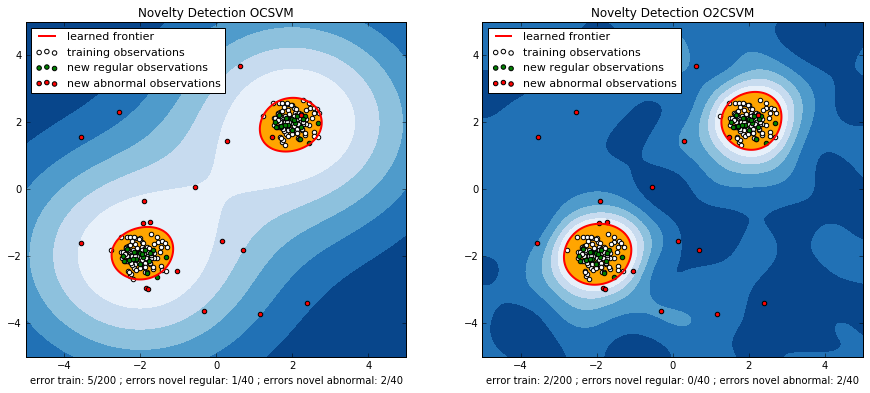

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn import svm

np.random.seed(0)
xx, yy = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-5, 5, 500))
# Generate train data
X = 0.3 * np.random.randn(100, 2)
X_train = np.r_[X + 2, X - 2]
# Generate some regular novel observations
X = 0.3 * np.random.randn(20, 2)
X_test = np.r_[X + 2, X - 2]
# Generate some abnormal novel observations
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))

# fit the model
clf = svm.OneClassSVM(nu=0.025, kernel="rbf", gamma=0.1)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size

# plot the line, the points, and the nearest vectors to the plane
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.title("Novelty Detection OCSVM")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.Blues_r)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='red')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='orange')

b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='green')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([a.collections[0], b1, b2, c],
           ["learned frontier", "training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left",
           prop=matplotlib.font_manager.FontProperties(size=11))
plt.xlabel(
    "error train: %d/200 ; errors novel regular: %d/40 ; "
    "errors novel abnormal: %d/40"
    % (n_error_train, n_error_test, n_error_outliers))


# fit the model
clf = OCCSVM(nu=0.01, gamma=4., T=10, D1=500)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size

# plot the line, the points, and the nearest vectors to the plane
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.subplot(1, 2, 2)
plt.title("Novelty Detection O2CSVM")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.Blues_r)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='red')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='orange')

b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='green')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([a.collections[0], b1, b2, c],
           ["learned frontier", "training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left",
           prop=matplotlib.font_manager.FontProperties(size=11))
plt.xlabel(
    "error train: %d/200 ; errors novel regular: %d/40 ; "
    "errors novel abnormal: %d/40"
    % (n_error_train, n_error_test, n_error_outliers))
plt.show()



Continuous one class svm.
________________________________________________________________________________
Modeling distribution of species 'bradypus variegatus'
 - fit OneClassContinuousSVM ... done.
 - plot coastlines from coverage
 - predict species distribution

 Area under the ROC curve : 0.860211
________________________________________________________________________________
Modeling distribution of species 'microryzomys minutus'
 - fit OneClassContinuousSVM ... done.
 - plot coastlines from coverage
 - predict species distribution

 Area under the ROC curve : 0.984737

time elapsed: 36.75s


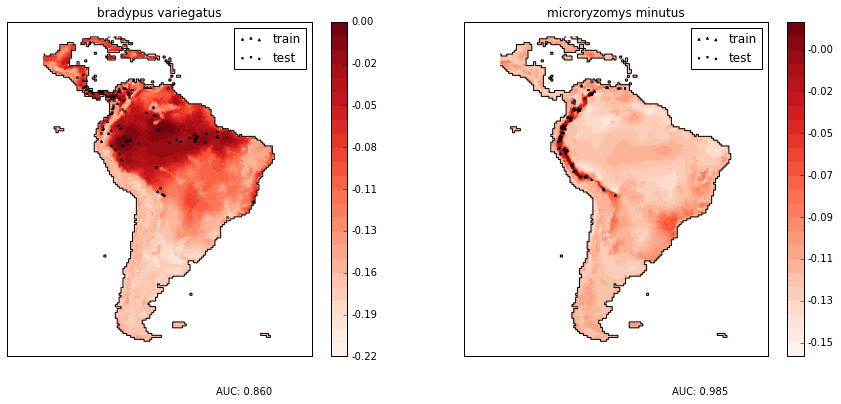

In [41]:
from __future__ import print_function

from time import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets.base import Bunch
from sklearn.datasets import fetch_species_distributions
from sklearn.datasets.species_distributions import construct_grids
from sklearn import svm, metrics

# if basemap is available, we'll use it.
# otherwise, we'll improvise later...
try:
    from mpl_toolkits.basemap import Basemap
    basemap = True
except ImportError:
    basemap = False

print(__doc__)


def create_species_bunch(species_name, train, test, coverages, xgrid, ygrid):
    """Create a bunch with information about a particular organism

    This will use the test/train record arrays to extract the
    data specific to the given species name.
    """
    bunch = Bunch(name=' '.join(species_name.split("_")[:2]))
    species_name = species_name.encode('ascii')
    points = dict(test=test, train=train)

    for label, pts in points.items():
        # choose points associated with the desired species
        pts = pts[pts['species'] == species_name]
        bunch['pts_%s' % label] = pts

        # determine coverage values for each of the training & testing points
        ix = np.searchsorted(xgrid, pts['dd long'])
        iy = np.searchsorted(ygrid, pts['dd lat'])
        bunch['cov_%s' % label] = coverages[:, -iy, ix].T

    return bunch


def plot_species_distribution(species=("bradypus_variegatus_0",
                                       "microryzomys_minutus_0")):
    """
    Plot the species distribution.
    """
    if len(species) > 2:
        print("Note: when more than two species are provided,"
              " only the first two will be used")

    t0 = time()

    # Load the compressed data
    data = fetch_species_distributions()

    # Set up the data grid
    xgrid, ygrid = construct_grids(data)

    # The grid in x,y coordinates
    X, Y = np.meshgrid(xgrid, ygrid[::-1])

    # create a bunch for each species
    BV_bunch = create_species_bunch(species[0],
                                    data.train, data.test,
                                    data.coverages, xgrid, ygrid)
    MM_bunch = create_species_bunch(species[1],
                                    data.train, data.test,
                                    data.coverages, xgrid, ygrid)

    # background points (grid coordinates) for evaluation
    np.random.seed(13)
    background_points = np.c_[np.random.randint(low=0, high=data.Ny,
                                                size=10000),
                              np.random.randint(low=0, high=data.Nx,
                                                size=10000)].T

    # We'll make use of the fact that coverages[6] has measurements at all
    # land points.  This will help us decide between land and water.
    land_reference = data.coverages[6]

    # Fit, predict, and plot for each species.
    plt.figure(figsize=(15, 6))
    for i, species in enumerate([BV_bunch, MM_bunch]):
        print("_" * 80)
        print("Modeling distribution of species '%s'" % species.name)

        # Standardize features
        mean = species.cov_train.mean(axis=0)
        std = species.cov_train.std(axis=0)
        train_cover_std = (species.cov_train - mean) / std

        # Fit OneClassSVM
        print(" - fit OneClassContinuousSVM ... ", end='')
        clf = OCCSVM(gamma=.15, T=100, step=.1, D1=700, D2=1)
#         clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.5)
        clf.fit(train_cover_std)
        print("done.")

        # Plot map of South America
        plt.subplot(1, 2, i + 1)
        if basemap:
            print(" - plot coastlines using basemap")
            m = Basemap(projection='cyl', llcrnrlat=Y.min(),
                        urcrnrlat=Y.max(), llcrnrlon=X.min(),
                        urcrnrlon=X.max(), resolution='c')
            m.drawcoastlines()
            m.drawcountries()
        else:
            print(" - plot coastlines from coverage")
            plt.contour(X, Y, land_reference,
                        levels=[-9999], colors="k",
                        linestyles="solid")
            plt.xticks([])
            plt.yticks([])

        print(" - predict species distribution")

        # Predict species distribution using the training data
        Z = np.ones((data.Ny, data.Nx), dtype=np.float64)

        # We'll predict only for the land points.
        idx = np.where(land_reference > -9999)
        coverages_land = data.coverages[:, idx[0], idx[1]].T

        pred = clf.decision_function((coverages_land - mean) / std)
        Z *= pred.min()
        Z[idx[0], idx[1]] = pred

        levels = np.linspace(Z.min(), Z.max(), 25)
        Z[land_reference == -9999] = -9999

        # plot contours of the prediction
        plt.contourf(X, Y, Z, levels=levels, cmap=plt.cm.Reds)
        plt.colorbar(format='%.2f')

        # scatter training/testing points
        plt.scatter(species.pts_train['dd long'], species.pts_train['dd lat'],
                    s=2 ** 2, c='black',
                    marker='^', label='train')
        plt.scatter(species.pts_test['dd long'], species.pts_test['dd lat'],
                    s=2 ** 2, c='black',
                    marker='x', label='test')
        plt.legend()
        plt.title(species.name)
        plt.axis('equal')

        # Compute AUC with regards to background points
        pred_background = Z[background_points[0], background_points[1]]
        pred_test = clf.decision_function((species.cov_test - mean) / std)
        scores = np.r_[pred_test, pred_background]
        y = np.r_[np.ones(pred_test.shape), np.zeros(pred_background.shape)]
        fpr, tpr, thresholds = metrics.roc_curve(y, scores)
        roc_auc = metrics.auc(fpr, tpr)
        plt.text(-35, -70, "AUC: %.3f" % roc_auc, ha="right")
        print("\n Area under the ROC curve : %f" % roc_auc)

    print("\ntime elapsed: %.2fs" % (time() - t0))


plot_species_distribution()
plt.show()

Continuous one class svm.
________________________________________________________________________________
Modeling distribution of species 'bradypus variegatus'
 - fit OneClassSVM ... done.
 - plot coastlines from coverage
 - predict species distribution

 Area under the ROC curve : 0.868380
________________________________________________________________________________
Modeling distribution of species 'microryzomys minutus'
 - fit OneClassSVM ... done.
 - plot coastlines from coverage
 - predict species distribution

 Area under the ROC curve : 0.993919

time elapsed: 5.19s


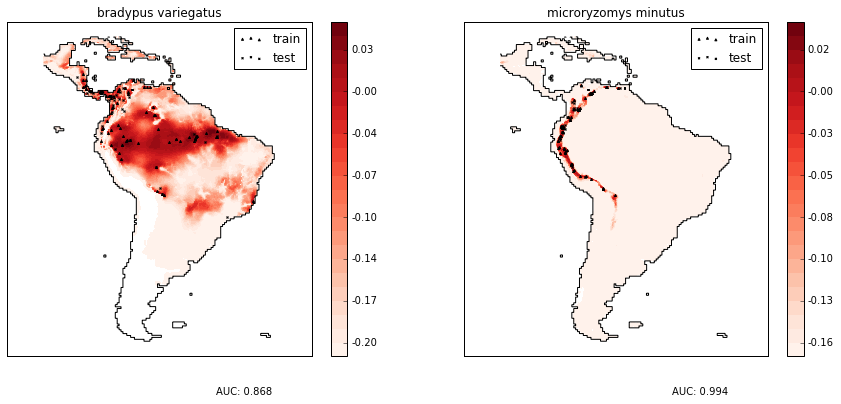

In [42]:
from __future__ import print_function

from time import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets.base import Bunch
from sklearn.datasets import fetch_species_distributions
from sklearn.datasets.species_distributions import construct_grids
from sklearn import svm, metrics

# if basemap is available, we'll use it.
# otherwise, we'll improvise later...
try:
    from mpl_toolkits.basemap import Basemap
    basemap = True
except ImportError:
    basemap = False

print(__doc__)


def create_species_bunch(species_name, train, test, coverages, xgrid, ygrid):
    """Create a bunch with information about a particular organism

    This will use the test/train record arrays to extract the
    data specific to the given species name.
    """
    bunch = Bunch(name=' '.join(species_name.split("_")[:2]))
    species_name = species_name.encode('ascii')
    points = dict(test=test, train=train)

    for label, pts in points.items():
        # choose points associated with the desired species
        pts = pts[pts['species'] == species_name]
        bunch['pts_%s' % label] = pts

        # determine coverage values for each of the training & testing points
        ix = np.searchsorted(xgrid, pts['dd long'])
        iy = np.searchsorted(ygrid, pts['dd lat'])
        bunch['cov_%s' % label] = coverages[:, -iy, ix].T

    return bunch


def plot_species_distribution(species=("bradypus_variegatus_0",
                                       "microryzomys_minutus_0")):
    """
    Plot the species distribution.
    """
    if len(species) > 2:
        print("Note: when more than two species are provided,"
              " only the first two will be used")

    t0 = time()

    # Load the compressed data
    data = fetch_species_distributions()

    # Set up the data grid
    xgrid, ygrid = construct_grids(data)

    # The grid in x,y coordinates
    X, Y = np.meshgrid(xgrid, ygrid[::-1])

    # create a bunch for each species
    BV_bunch = create_species_bunch(species[0],
                                    data.train, data.test,
                                    data.coverages, xgrid, ygrid)
    MM_bunch = create_species_bunch(species[1],
                                    data.train, data.test,
                                    data.coverages, xgrid, ygrid)

    # background points (grid coordinates) for evaluation
    np.random.seed(13)
    background_points = np.c_[np.random.randint(low=0, high=data.Ny,
                                                size=10000),
                              np.random.randint(low=0, high=data.Nx,
                                                size=10000)].T

    # We'll make use of the fact that coverages[6] has measurements at all
    # land points.  This will help us decide between land and water.
    land_reference = data.coverages[6]

    # Fit, predict, and plot for each species.
    plt.figure(figsize=(15, 6))
    for i, species in enumerate([BV_bunch, MM_bunch]):
        print("_" * 80)
        print("Modeling distribution of species '%s'" % species.name)

        # Standardize features
        mean = species.cov_train.mean(axis=0)
        std = species.cov_train.std(axis=0)
        train_cover_std = (species.cov_train - mean) / std

        # Fit OneClassSVM
        print(" - fit OneClassSVM ... ", end='')
        clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.5)
        clf.fit(train_cover_std)
        print("done.")

        # Plot map of South America
        plt.subplot(1, 2, i + 1)
        if basemap:
            print(" - plot coastlines using basemap")
            m = Basemap(projection='cyl', llcrnrlat=Y.min(),
                        urcrnrlat=Y.max(), llcrnrlon=X.min(),
                        urcrnrlon=X.max(), resolution='c')
            m.drawcoastlines()
            m.drawcountries()
        else:
            print(" - plot coastlines from coverage")
            plt.contour(X, Y, land_reference,
                        levels=[-9999], colors="k",
                        linestyles="solid")
            plt.xticks([])
            plt.yticks([])

        print(" - predict species distribution")

        # Predict species distribution using the training data
        Z = np.ones((data.Ny, data.Nx), dtype=np.float64)

        # We'll predict only for the land points.
        idx = np.where(land_reference > -9999)
        coverages_land = data.coverages[:, idx[0], idx[1]].T

        pred = clf.decision_function((coverages_land - mean) / std)[:, 0]
        Z *= pred.min()
        Z[idx[0], idx[1]] = pred

        levels = np.linspace(Z.min(), Z.max(), 25)
        Z[land_reference == -9999] = -9999

        # plot contours of the prediction
        plt.contourf(X, Y, Z, levels=levels, cmap=plt.cm.Reds)
        plt.colorbar(format='%.2f')

        # scatter training/testing points
        plt.scatter(species.pts_train['dd long'], species.pts_train['dd lat'],
                    s=2 ** 2, c='black',
                    marker='^', label='train')
        plt.scatter(species.pts_test['dd long'], species.pts_test['dd lat'],
                    s=2 ** 2, c='black',
                    marker='x', label='test')
        plt.legend()
        plt.title(species.name)
        plt.axis('equal')

        # Compute AUC with regards to background points
        pred_background = Z[background_points[0], background_points[1]]
        pred_test = clf.decision_function((species.cov_test - mean)
                                          / std)[:, 0]
        scores = np.r_[pred_test, pred_background]
        y = np.r_[np.ones(pred_test.shape), np.zeros(pred_background.shape)]
        fpr, tpr, thresholds = metrics.roc_curve(y, scores)
        roc_auc = metrics.auc(fpr, tpr)
        plt.text(-35, -70, "AUC: %.3f" % roc_auc, ha="right")
        print("\n Area under the ROC curve : %f" % roc_auc)

    print("\ntime elapsed: %.2fs" % (time() - t0))


plot_species_distribution()
plt.show()